In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

In [2]:
class OrderParameter:

    # name should be unique to the Order Parameter being defined
    # In other words for every possible pair of OP's x and y, (x.name != y.name) must be true
    def __init__(self, name, traj):
        self.name = name
        self.traj = traj
        
    def __eq__(self, other):
        return self.name == other.name
    
    def __hash__(self):
        return hash(self.name)
        
    def __str__(self):
        return str(self.name)

In [3]:
def distortion(centers, ops, mut):
    dis = 0.0
    for i in ops:
        min_val = np.inf
        for j in centers:
            tmp = mut.iqr(i, j)
            if tmp < min_val:
                min_val = tmp
        dis = dis + (min_val * min_val)
    return dis ** (0.5)

In [4]:
class DissimilarityMatrix:

    def __init__(self, max_OPs, mut):
        self.max_OPs = max_OPs
        self.matrix = [[] for i in range(max_OPs)]
        self.mut = mut
        self.OPs = []

    def add_OP(self, OP):
        if len(self.OPs) == self.max_OPs:
            mut_info = []
            existing = []
            for i in range(len(self.OPs)):
                mut_info.append(self.mut.iqr(self.OPs[i], OP))
                product = 1
                for j in range(len(self.OPs)):
                    if not i == j:
                        product = product * self.matrix[i][j]
                existing.append(product)
            update = False
            difference = None
            for i in range(len(self.OPs)):
                candidate_info = 1
                for j in range(len(self.OPs)):
                    if not i == j:
                        candidate_info = candidate_info * mut_info[j]
                if candidate_info > existing[i]:
                    update = True
                    if difference == None:
                        difference = candidate_info - existing[i]
                        old_OP = i
                    else:
                        if (candidate_info - existing[i]) > difference:
                            difference = candidate_info - existing[i]
                            old_OP = i
            if update == True:
                mut_info[old_OP] = self.mut.iqr(OP, OP)
                self.matrix[old_OP] = mut_info
                self.OPs[old_OP] = OP
                for i in range(len(self.OPs)):
                    self.matrix[i][old_OP] = mut_info[i]
        else:
            for i in range(len(self.OPs)):
                mut_info = self.mut.iqr(OP, self.OPs[i])
                self.matrix[i].append(mut_info)
                self.matrix[len(self.OPs)].append(mut_info)
            self.matrix[len(self.OPs)].append(self.mut.iqr(OP, OP))
            self.OPs.append(OP)
        
    def reduce(self):
        min_val = 10
        index = -1
        for i in range(len(self.matrix)):
            product = 1
            for j in range(len(self.matrix[i])):
                if not i == j:
                    product = product * self.matrix[i][j]
            if product < min_val:
                index = i
                min_val = product
        self.matrix.pop(index)
        for i in range(len(self.matrix)):
            self.matrix[i].pop(index)
        self.OPs.pop(index)
        
    def min_product(self):
        min_val = 10
        for i in range(len(self.matrix)):
            product = 1
            for j in range(len(self.matrix[i])):
                if not i == j:
                    product = product * self.matrix[i][j]
            if product < min_val:
                min_val = product
        return min_val
    
    def get_OPs(self):
        return self.OPs
    
    def __str__(self):
        output = ""
        output = output + "OPs:\n"
        for i in self.OPs:
            output = output + str(i) + "\n"
        output = output + "\nMatrix:\n"
        for i in self.matrix:
            for j in i:
                output = output + str(j) + " "
            output = output + "\n"
        return output
                

In [5]:
def d1_bin(x, bins = 80):

    min_val = np.amin(x)
    max_val = np.amax(x)
    span = max_val - min_val

    p_x = [0.0 for i in range(bins)]

    for i in x:
        bin_num = (int) (bins * (i - min_val) / span)
        if bin_num == bins:
            bin_num -= 1
        p_x[bin_num] += 1.0 / len(x)

    return p_x

In [6]:
def d2_bin(x, y, bins = 80):

    if len(x) != len(y):
        raise Exception("Order parameter lists are of different size.")

    min_x = np.amin(x)
    max_x = np.amax(x)
    span_x = max_x - min_x

    min_y = np.amin(y)
    max_y = np.amax(y)
    span_y = max_y - min_y

    p_xy = [[0.0 for i in range(bins)] for j in range(bins)]

    for i in range(len(x)):
        bin_x = (int) (bins * (x[i] - min_x) / span_x)
        bin_y = (int) (bins * (y[i] - min_y) / span_y)
        if bin_x == bins:
            bin_x -= 1
        if bin_y == bins:
            bin_y -= 1
        p_xy[bin_x][bin_y] += 1.0 / len(x)

    return p_xy

In [7]:
class Memoizer:
    
    def __init__(self):
        self.memo = {}
        self.bins = 80
        
    def iqr(self, OP1, OP2):
        index = str(OP1.name) + " " + str(OP2.name)
        if index in self.memo:
            return self.memo[index]
        else:
            x = OP1.traj
            y = OP2.traj
            p_x = d1_bin(x, self.bins)
            p_y = d1_bin(y, self.bins)
            p_xy = d2_bin(x, y, self.bins)

            info = 0
            entropy = 0

            for i in range(len(p_x)):
                for j in range(len(p_y)):
                    if p_xy[i][j] != 0:
                        entropy -= p_xy[i][j] * np.log(p_xy[i][j])
                        info += p_xy[i][j] * np.log(p_xy[i][j] / (p_x[i] * p_y[j]))

            if ((1 - (info / entropy)) < 0):
                output = 0.0
            else:
                output = (1 - (info / entropy))
            self.memo[index] = output
            return output
    
    def __str__(self):
        print(len(self.memo))

In [8]:
def grouping(new_OPs, all_OPs, mut):
    groups = [[] for i in range(len(new_OPs))]
    for OP in all_OPs:
        group = 0
        for i in range(len(new_OPs)):
            tmp = mut.iqr(OP, new_OPs[i])
            if tmp < mut.iqr(OP, new_OPs[group]):
                group = i
        groups[group].append(OP)
    return groups

In [9]:
def group_evaluation(OPs, mut):
    
    center = OPs[0]
    min_distortion = distortion([OPs[0]], OPs, mut)
    
    for i in OPs:
        tmp = distortion([i], OPs, mut)
        if tmp < min_distortion:
            center = i
            min_distortion = tmp

    return center

In [10]:
def cluster(ops, seeds, mut):
    
    old_centers = []
    centers = copy.deepcopy(seeds)
    
    while (set(centers) != set(old_centers)):
        
        old_centers = copy.deepcopy(centers)
        centers = []
        groups = grouping(old_centers, ops, mut)
        
        for i in range(len(groups)):
            result = group_evaluation(groups[i], mut)
            centers.append(result)

    return centers


In [38]:
def find_ops(old_ops, max_outputs, mut):
    
    matrix = DissimilarityMatrix(max_outputs, mut)
    
    for i in old_ops:
        matrix.add_OP(i)
        
    for i in old_ops[::-1]:
        matrix.add_OP(i)
        
    while (len(matrix.OPs) > 20):
        matrix.reduce()
    
    tmp = copy.deepcopy(matrix)
    distortion_array = []
    num_array = []

    for i in range(len(matrix.OPs) - 1):
        num_array.append(len(tmp.OPs))
        seed = []
        for i in tmp.OPs:
            seed.append(i)
        tmp_ops = cluster(old_ops, seed, mut)
        distortion_array.append(distortion(tmp_ops, old_ops, mut))
        tmp.reduce()

    distortion_array = np.array(distortion_array) ** (-0.5)
    new_nums = []
    jumps = []
    
    for i in range(len(distortion_array) - 1):
        new_nums.append(str(num_array[i]))
        
    
    for i in range(10):
        local = np.array(copy.deepcopy(distortion_array))
        local = local ** (i * -0.5)
        jumps = []
        for j in range(len(local) - 1):
            jumps.append(local[j] - local[j + 1])
        plt.plot(new_nums, jumps, label=str(i * -0.5))
    
    plt.xlabel("Number of Order Parameters(k)")
    plt.ylabel("Jump in Distortion J(k)")
    plt.legend(loc='upper left')
    plt.show()
    return plt
    
    '''
    min_index = 0
    for i in range(len(jumps)):
        if jumps[i] > jumps[min_index]:
            min_index = i
    
    while (len(matrix.OPs) > num_array[min_index]):
        matrix.reduce()
        
    return cluster(old_ops, matrix.OPs, mut)'''


In [12]:
def gen_two():
    traj = []
    for i in range(50000):
        tmp = random.random()
        tmp = 1 - (tmp * tmp * tmp * tmp)
        if random.random() < 0.5:
            tmp = -1 * tmp
        traj.append(tmp)
    return traj

In [13]:
def gen_three():
    traj = []
    for i in range(50000):
        tmp = random.random()
        tmp = (tmp * tmp * tmp * tmp)/2
        if random.random() < 0.5:
            tmp = 1 - tmp
        if random.random() < 0.5:
            tmp = -1 * tmp
        traj.append(tmp)
    return traj

In [14]:
def add_noise(traj):
    new_traj = []
    for i in traj:
        new_traj.append(i + (random.random() / 10) - 0.05)
    return new_traj

In [15]:
def rand_insert(lst, ele):
    lst.insert(random.randrange(len(lst) + 1), ele)

In [16]:
def make_OP(name, num, num_wells, ops):
    
    original = None
    if num_wells == 2:
        original = gen_two()
    elif num_wells == 3:
        original = gen_three()
    else:
        raise Exception("I've only built in distribution generators for 2 and 3 well OP's.")
        
    rand_insert(ops, OrderParameter(name, original))
    
    for i in range(num - 1):
        rand_insert(ops, OrderParameter(name + str(i + 1), add_noise(original)))
        
    return None
        

In [22]:
ops = []
make_OP("A", 14, 2, ops)
make_OP("B", 10, 2, ops)
make_OP("C", 14, 3, ops)
make_OP("D", 10, 3, ops)
make_OP("E", 14, 2, ops)
make_OP("F", 10, 2, ops)
make_OP("G", 14, 2, ops)
make_OP("H", 10, 3, ops)
make_OP("I", 14, 3, ops)
make_OP("J", 10, 2, ops)
mut = Memoizer()

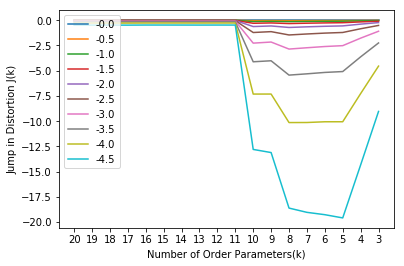

<module 'matplotlib.pyplot' from 'C:\\Users\\Pavan\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [39]:
find_ops(ops, 20, mut)

In [19]:
def dissim(ops, k, mut):
    matrix = DissimilarityMatrix(k, mut)
    for i in ops:
        matrix.add_OP(i)
    
    return matrix.OPs

mut = Memoizer()
four = dissim(ops, 9, mut)
five = dissim(ops, 10, mut)
six = dissim(ops, 11, mut)
print("FOUR DISSIM")
for i in four:
    print(i)
    
print("\nFIVE DISSIM")
for i in five:
    print(i)
    
print("\nSEIX DISSIM")
for i in six:
    print(i)
    

print("\nFOUR CLUS")
four = cluster(ops, four, mut)
for i in four:
    print(i)


print("\nFIVE CLUS")
five = cluster(ops, five, mut)
for i in five:
    print(i)

print("\nSIX CLUS")
six = cluster(ops, six, mut)
for i in six:
    print(i)

FOUR DISSIM
H2
B1
G3
A13
D4
E13
I11
C4
J1

FIVE DISSIM
H2
F8
B8
A11
I9
D4
G12
C6
J1
E8

SEIX DISSIM
H2
F5
B1
I3
A9
G8
J8
C4
J1
E12
D3

FOUR CLUS
H
B
G
A
D
E
I
C
J

FIVE CLUS
H
F
B
A
I
D
G
C
J
E

SIX CLUS
H
F
B
I
A
G
J3
C
J
E
D


In [18]:
final_ops = find_ops(ops, 30)

In [21]:
print("Number of Order Parameters: " + str(len(ops)))
for i in final_ops:
    print(i.name)
print("\nAll order Parmeters:")
for i in ops:
    print(i.name)

Number of Order Parameters: 120
G
I
F
C
A
D
H
J
E

All order Parmeters:
J6
G
E8
I8
F6
A2
H5
G3
B7
C
A13
C3
D8
G5
H6
J7
E
C4
C12
E10
J1
F2
H
C13
I9
E4
D6
H1
J3
E12
F7
C5
D5
A3
D2
G12
B1
E5
G13
F5
J2
J
D3
D
C2
D7
C1
E3
C11
J4
G9
H8
G2
B2
G10
J8
G7
F8
I2
A12
A
F3
G6
C10
E6
A10
I
E11
D9
H7
A7
I10
C6
A1
I3
E7
B6
D4
A9
E9
A8
A4
J5
H2
J9
G4
F4
E2
A6
G8
B9
G1
I4
C9
B5
I7
B
I13
I6
H4
D1
H3
B8
C7
A5
F1
E13
I12
G11
F
I11
A11
F9
B3
I5
H9
B4
I1
E1
C8
